# Setup

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

from ipywidgets import interact, widgets, fixed
from plotly.express import imshow as imshow_interactive

## Import core modules

In [2]:
import sys
import pathlib
SRC_DIR = str(pathlib.Path(__name__).resolve().parent.parent)
sys.path.append(SRC_DIR)

In [3]:
from scanplot.setup_logger import logger

In [4]:
from scanplot.utils.read_image import read_image_rgb
from scanplot.utils.drawing import draw_image, draw_points_on_canvas, draw_points_on_image
from scanplot.utils.widgets import init_points_num_slider, init_points_density_slider

In [5]:
from scanplot.core.template_match import template_match
from scanplot.core.preprocess import replace_black_pixels
from scanplot.core.conv_map_operations import normalize_map
from scanplot.core.process_template import template_tresholding, crop_image, reconstruct_template_mask
from scanplot.core.hough_transform import generalized_hough_transform
from scanplot.core.parameters_search import linear_parameter_transform, get_corr_map_maximums
from scanplot.core.nms import apply_nms

# Algorithm Pipeline

## Upload plot image and template image

Input data examples can be found in `<REPOSITORY>/sample_data/`.

In [6]:
DATA_PATH = pathlib.Path("../../sample_data/")

In [7]:
PLOT_NUMBER = 59
MARKER_NUMBER = 1

PLOT_PATH = DATA_PATH / "plot_images" / f"plot{PLOT_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "marker_images" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"

In [8]:
source_image = read_image_rgb(PLOT_PATH)
source_template = read_image_rgb(TEMPLATE_PATH)

image = replace_black_pixels(source_image)
template = replace_black_pixels(source_template)

h_image, w_image = image.shape[0], image.shape[1]
h_template, w_template = template.shape[0], template.shape[1]

DEBUG - preprocess.py - replace_black_pixels: Number of black pixels on image: 3
DEBUG - preprocess.py - replace_black_pixels: Number of black pixels on image: 0


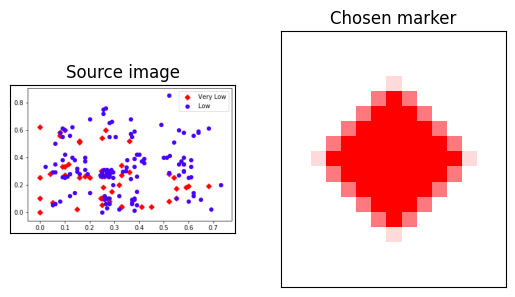

In [9]:
plt.subplot(1, 2, 1)
draw_image(image)
plt.title("Source image")
plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
draw_image(template)
plt.title("Chosen marker")
plt.xticks([]); plt.yticks([]);

## Tresholding

In [10]:
TRESHOLD_VALUE = 190
template_mask = template_tresholding(template, TRESHOLD_VALUE)
new_template_mask = reconstruct_template_mask(template_mask)

# fig = plt.figure()
# plt.subplot(1, 2, 1)
# draw_image(template_mask)
# plt.xticks([]); plt.yticks([])

# plt.subplot(1, 2, 2)
# draw_image(new_template_mask)
# plt.xticks([]); plt.yticks([]);

## Template matching

Run template matching algorithm and compute convolutoin (or correlatoin) map.

In [11]:
method = "cv.TM_SQDIFF_NORMED"

convolution_map, _ = template_match(image, template, template_mask, method)
convolution_map2, _ = template_match(image, template, new_template_mask, method)

DEBUG - template_match.py - template_match: Convolution map bounds: (0.0, 1.2531257)
DEBUG - template_match.py - template_match: Convolution map was inverted
DEBUG - template_match.py - template_match: Convolution map bounds: (0.0, 1.2531257)
DEBUG - template_match.py - template_match: Convolution map was inverted


## Hough transform

In [12]:
accumulator = generalized_hough_transform(image, template, norm_result=True, crop_result=True)

assert convolution_map.shape == accumulator.shape

## Combine convolution maps

This step combines correlation map obtained by template matching algorithm and accumulator array from Hough Transform.

In [13]:
convolution_map = normalize_map(convolution_map)
convolution_map2 = normalize_map(convolution_map2)

convolution_map_combined = convolution_map + 0.7 * convolution_map2
convolution_map_combined = normalize_map(convolution_map_combined)

convolution_map_with_hough = convolution_map + 0.6 * accumulator
convolution_map_with_hough = normalize_map(convolution_map_with_hough)

In [14]:
# imshow_interactive(convolution_map_with_hough)

## Algorithm parameters

The algorithm has 2 parameters:
- Points Number
- Points Density


The impact of these parameters on the final result is shown in the images below:

![](../../readme_images/parameter_search_1.png)

![](../../readme_images/parameter_search_2.png)

In [15]:
def detect_points_on_map(
        points_num: float,
        points_density: float,
        correlation_map: np.ndarray,
        draw_detections: bool = True,
        return_result: bool = False,
        figure_size: int = 10,
        marker_size: int = 60,
        marker_color: str = "yellow"
) -> np.ndarray | None:
    
    ## transform parameters
    corr_map_treshold = linear_parameter_transform(points_num, a=-0.01, b=1)
    iou_treshold = linear_parameter_transform(points_density, a=-0.01, b=1)

    ## get max points
    max_points, _ = get_corr_map_maximums(
        correlation_map=correlation_map,
        treshold=corr_map_treshold
    )
    
    ## NMS
    actual_points = apply_nms(
        points=max_points,
        correlation_map=correlation_map,
        iou_treshold=iou_treshold,
        bbox_width=w_template,   # TODO: this is global variable, pass as paramrter
        bbox_height=h_template   # TODO: this is global variable, pass as paramrter
    )
    x_nms = actual_points[:, 0]
    y_nms = actual_points[:, 1]
    number_of_points = len(actual_points)

    ## draw founded points on original image
    if draw_detections:
        plt.figure(figsize=(figure_size, figure_size))
        draw_image(source_image)  # TODO: this is global variable, pass as paramrter
        plt.scatter(x_nms, y_nms, 
                    s=marker_size, c=marker_color, marker="*", 
                    edgecolors='black', linewidths=0.2)
        plt.xticks([]); plt.yticks([])
        plt.title(f"Number of Points: {number_of_points}")
        plt.show()

    if return_result:
        return actual_points

## Interactive parameters search with ipywidgets

In [ ]:
# parameters for drawing detections (may be customized)
figure_size = 12
marker_size = 200
marker_color = "yellow"


interact(
    detect_points_on_map,
    points_num=init_points_num_slider(),
    points_density=init_points_density_slider(),
    correlation_map=fixed(convolution_map_with_hough),
    draw_detections=fixed(True),
    return_result=fixed(False),
    figure_size=fixed(figure_size),
    marker_size=fixed(marker_size),
    marker_color=fixed(marker_color),
    continuous_update=True
);

interactive(children=(FloatSlider(value=20.0, description='Points Number:', layout=Layout(width='500px'), read…

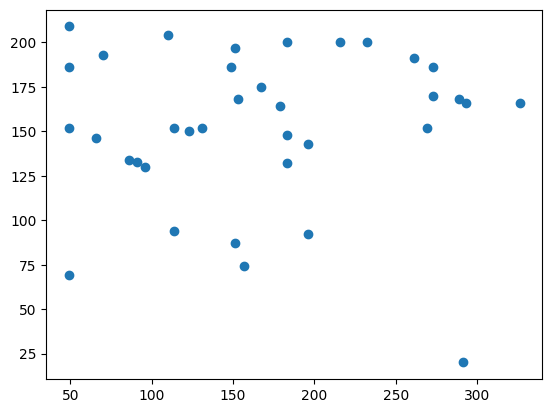

In [17]:
optimal_points_num = 56
optimal_points_density = 50

points = detect_points_on_map(
    points_num=optimal_points_num,
    points_density=optimal_points_density,
    correlation_map=convolution_map_with_hough,
    draw_detections=False,
    return_result=True
)

# points coordinates in pixels (!)
x = points[:, 0]
y = points[:, 1]
plt.scatter(x, y)